In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
from transformers import GPT2TokenizerFast, GPT2LMHeadModel
from nltk.metrics.distance import edit_distance
from difflib import SequenceMatcher

In [2]:
# adapted from Ruan on stackoverflow
class GPT2:
    def __init__(self):
        self.model = GPT2LMHeadModel.from_pretrained("gpt2")
        self.tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
    
    def get_predictions(self, sentence):
        # Encode the sentence using the tokenizer and return the model predictions.
        inputs = self.tokenizer.encode(sentence, return_tensors="pt")
        with torch.no_grad():
            outputs = self.model(inputs)
            predictions = outputs[0]
        return predictions
    
    def get_next_word_probabilities(self, sentence, n=50257):
        predictions = self.get_predictions(sentence)
        next_token_candidates_tensor = predictions[0, -1, :] # Get the next token candidates.
        topk_candidates_indexes = torch.topk(
            next_token_candidates_tensor, n).indices.tolist() # Get the top k next token candidates.
        all_candidates_probabilities = torch.nn.functional.softmax( # Get the token probabilities for all candidates.
            next_token_candidates_tensor, dim=-1)
        topk_candidates_probabilities = \
            all_candidates_probabilities[topk_candidates_indexes].tolist() # Filter the token probabilities for the top k candidates.
        topk_candidates_tokens = \
            [self.tokenizer.decode([idx]).strip() for idx in topk_candidates_indexes] # Decode the top k candidates back to words.
        return list(zip(topk_candidates_tokens, topk_candidates_probabilities))
        
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()
    
model = GPT2()

In [3]:
probs  = model.get_next_word_probabilities("Hi Michael,\nMy office", 10000)
target = 'ours'
probsp = [(word, prob, similar(target, word)) for word, prob in probs]
target_probs = sorted(probsp, key=lambda x: x[2], reverse=True)
if target_probs[0][2] == 1:
    target_prob = target_probs[0][1]
else:
    target_prob = 0
probsp[:10]

[('is', 0.34098055958747864, 0.3333333333333333),
 ('has', 0.09880493581295013, 0.2857142857142857),
 ('was', 0.05582132562994957, 0.2857142857142857),
 (',', 0.02886134758591652, 0.0),
 ("'s", 0.022105982527136803, 0.3333333333333333),
 ('manager', 0.02020064741373062, 0.18181818181818182),
 ('in', 0.015417988412082195, 0.0),
 ('and', 0.013899797573685646, 0.0),
 ('will', 0.013379140757024288, 0.0),
 ('at', 0.012275890447199345, 0.0)]

In [4]:
target_probs[:10], target_prob

([('hours', 0.0016791245434433222, 0.8888888888888888),
  ('Hours', 1.422804325557081e-05, 0.8888888888888888),
  ('yours', 3.526459977365448e-06, 0.8888888888888888),
  ('tours', 3.16972000291571e-06, 0.8888888888888888),
  ('our', 4.3834825191879645e-05, 0.8571428571428571),
  ('ors', 2.9956318030599505e-06, 0.8571428571428571),
  ('our', 1.5129901385080302e-06, 0.8571428571428571),
  ('course', 4.391630682221148e-06, 0.8),
  ('occurs', 3.0063470148888882e-06, 0.8),
  ('your', 0.00010985739208990708, 0.75)],
 0)

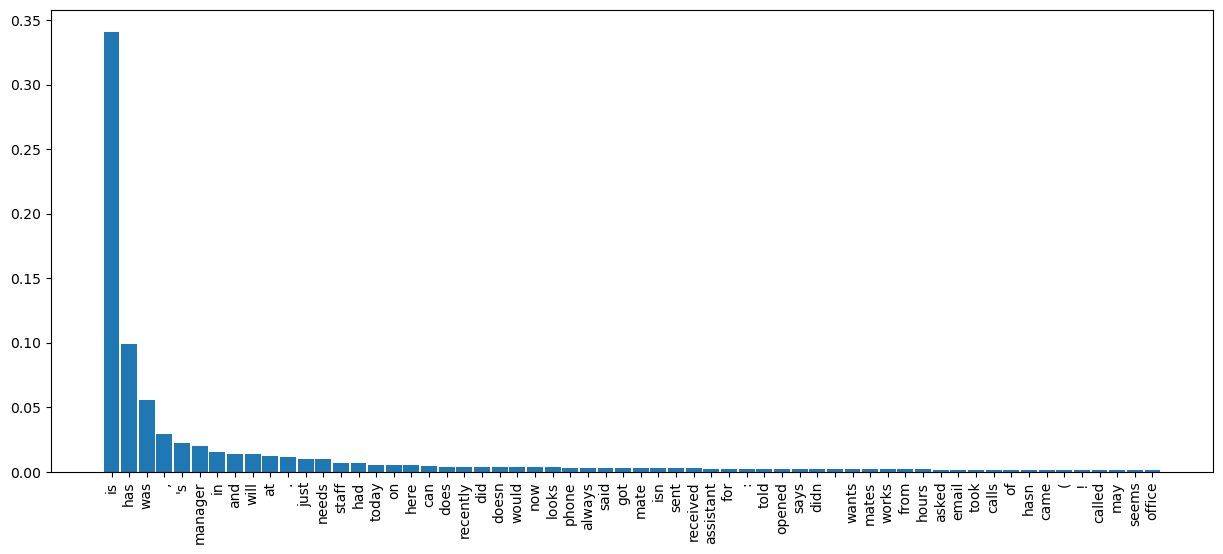

In [5]:
fig, ax = plt.subplots(figsize=(15,6))
probs = np.array(probsp[:60])
ax.bar(probs[:,0], probs[:,1].astype(float), width=0.9)
plt.xticks(rotation=90, fontsize=10)
plt.show()

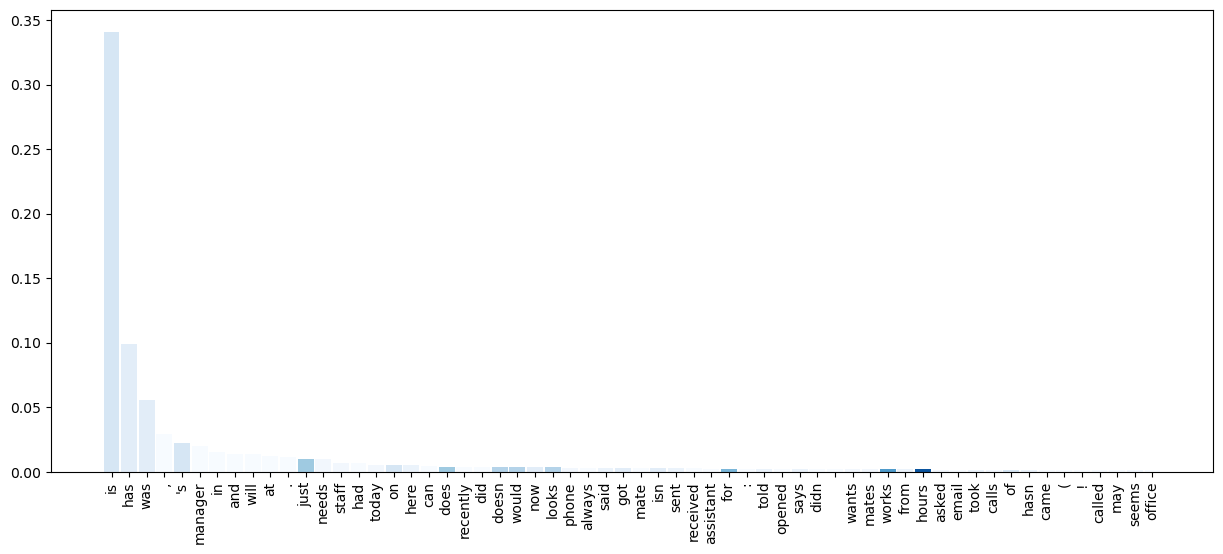

In [6]:
fig, ax = plt.subplots(figsize=(15,6))
cmap = mpl.colormaps['Blues']
norm = mpl.colors.Normalize(vmin=0.2, vmax=1)
ax.bar(probs[:,0], probs[:,1].astype(float), color=cmap(norm(probs[:,2].astype(float))), width=0.9)
plt.xticks(rotation=90, fontsize=10)
plt.show()

In [7]:
#adjusted_prob = [(word, prob, prob/((dist+1)**2), dist) for word, prob, dist in probsp if dist <= 2] # probability inversely proportional to distance squared
#adjsuted_prob = sorted(adjusted_prob, key=lambda x: x[1], reverse=True)
#adjusted_prob[:5]
close_prob = [(word, prob, sim) for word, prob, sim in probsp if sim >= 0.6]
close_prob[:5]

[('works', 0.001758794765919447, 0.6666666666666666),
 ('hours', 0.0016791245434433222, 0.8888888888888888),
 ('or', 0.0008658771403133869, 0.6666666666666666),
 ('offers', 0.0003631694125942886, 0.6),
 ('sounds', 0.00024852502974681556, 0.6)]

In [8]:
adjusted_prob = [(word, prob, prob/((max((1-sim)+0.9, 1)**8)), sim) for word, prob, sim in probsp[:100] if sim >= 0.6] # probability inversely proportional to distance squared
sorted(adjusted_prob, key=lambda x: x[2], reverse=True)[:5]

[('hours', 0.0016791245434433222, 0.0015370636307352433, 0.8888888888888888),
 ('works', 0.001758794765919447, 0.0003285272586097531, 0.6666666666666666),
 ('or', 0.0008658771403133869, 0.00016173816792734193, 0.6666666666666666)]

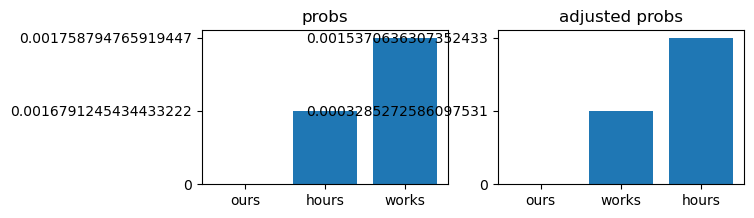

In [9]:
top_n = 2
adj_probs = sorted(adjusted_prob, key=lambda x: x[2], reverse=True)[:top_n]
adj_probs.append((target, target_prob, target_prob, 1))
adj_probs = np.array(sorted(adj_probs, key=lambda x: x[1]))
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(7, 2))
ax1.bar(adj_probs[:,0], adj_probs[:,1])
adj_probs = np.array(sorted(adj_probs, key=lambda x: x[2]))
ax2.bar(adj_probs[:,0], adj_probs[:,2])
ax1.set_title("probs")
ax2.set_title("adjusted probs")
plt.show()

In [10]:
def getSuggestions(string, n=1):
    words  = string.split()
    prompt = ' '.join(words[:-1])
    target = words[-1]
    probs  = model.get_next_word_probabilities(prompt, 10000)
    probsp = [(word, prob, similar(target, word)) for word, prob in probs]
    adjusted_prob = [(word, prob, prob/(((1-sim)+1)**6), sim) for word, prob, sim in probsp[:50] if sim >= 0.5]
    close_prob = [(word, prob, sim) for word, prob, sim in probsp if sim >= 5]
    closest = sorted(probsp, key=lambda x: x[2], reverse=True)[0]
    if closest[2]:
        target_prob = closest[1]
    else:
        target_prob = None
    return sorted(adjusted_prob, key=lambda x: x[2], reverse=True)[:n], target_prob

In [11]:
getSuggestions("Hi Michael,\n\nMy office ours", 3)

([('just', 0.011888855136930943, 0.0010437403686743214, 0.5),
  ('hours', 0.0016539501957595348, 0.0008789769459846428, 0.8888888888888888),
  ('for', 0.0029658344574272633, 0.00034892745808186006, 0.5714285714285714)],
 0.0016539501957595348)